#Multiple Output [Cardiac, Respiratory] Evaluate Model PSG-Audio

This version forked from Cardiac equivalent 2/10/2023.   Results from cardiac alone are still challenging.

Author:  [Lee B. Hinkle](https://userweb.cs.txstate.edu/~lbh31/), [IMICS Lab](https://imics.wp.txstate.edu/), Texas State University, 2023


<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.

TODO:

* Tuning and general model improvements, the inputs currently are not sample weighted.

# Imports

In [1]:
import os
import shutil
import time
from datetime import datetime
from datetime import date
from datetime import timedelta # for calculating training time
from random import randrange # for plotting samples
import numpy as np
import matplotlib.pyplot as plt # for plotting training curves
from tabulate import tabulate # for verbose tables, showing data
import tensorflow as tf
from tensorflow import keras #added to save model
from tensorflow.keras import layers #format matches MNIST example
from tensorflow.keras.callbacks import EarlyStopping
#imports for computing and displaying output metrics
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import compute_sample_weight
import sys
import urllib.request # to get files from web w/o !wget
from shutil import unpack_archive # to unzip

In [2]:
interactive = True # this is an interactive notebook, keeping this for compatibility

# Get small or full processed PSG-Audio numpy arrays
See PSG-Audio_load_dataset_for_multi-output.ipynb for info, this is source of the arrays.


In [3]:
use_small = True # arrays are 1/10th the size for shorter download/train time
# From readme
# PSG-Audio data subs at 3s window and 3s step.
# Saved to /content/drive/MyDrive/Processed_Datasets/PSG-Audio/PSG_12ch_90_10_3s_3s
# Generated by PSG-Audio_load_dataset_for_multi-output.ipynb on Jan-31-2023_1956
# this version for multi-outout cardio/respiratory work
# contains data 9 200Hz channels downsample to 100Hz and
# One in five subs allocated to test.
# balance of subs in train, intent is to use groupkfold
# along with the sub array that is also saved
# this version discards extremely rare events in train
# and also collapses remaining cardio to normal(0), abnormal(1)
# and puts all resp:apnea into a single event(1) along with
# keeping hyponea.  So resp: normal, apnea, hyponea
working_dir = "." # just to stay compatible, gdown uses current dir.
if use_small:
    version = "small"
    print("Downloading small arrays")
    flist = ["small_x_train.npy", "small_y_train.npy", "small_sub_train.npy"]
    !gdown "1zo_Amyb_vbAL1VKpa1IKtuHpL5Gw9IaG&confirm=t" # small_x_train
    !gdown "1_ZFknIBTNaCS7lCILDM0loUOFUUzz8EZ&confirm=t" # small_y_train
    !gdown "1KbOqMdPlOUaT1TQMY_NTp-oKqnRzelfb&confirm=t" # small_sub_train

    X = np.load(os.path.join(working_dir, 'small_x_train.npy'))
    y = np.load(os.path.join(working_dir, 'small_y_train.npy'))
    sub = np.load(os.path.join(working_dir, 'small_sub_train.npy'))
else:
    version = "full"
    print("Downloading full arrays - will require a high-RAM runtime")
    flist = ["x_train.npy", "y_train.npy", "sub_train.npy"]
    !gdown "1-trnx46IB9oFaTeSIbCNL4XxJq4gifsh&confirm=t" # x_train
    !gdown "105A0smVAjmJ_bEOuAAbHsHRR79PawcBm&confirm=t" # y_train
    !gdown "1-w2Kpzg48MNUv1t82Zfn_p2axllcn-rJ&confirm=t" # sub_train

    X = np.load(os.path.join(working_dir, 'x_train.npy'))
    y = np.load(os.path.join(working_dir, 'y_train.npy'))
    sub = np.load(os.path.join(working_dir, 'sub_train.npy'))   

headers = ("Array","shape", "data type")
mydata = [("X:", X.shape, X.dtype),
        ("y:", y.shape, y.dtype),
        ("sub:", sub.shape, sub.dtype)]
print("\n",tabulate(mydata, headers=headers))

Downloading...
From: https://drive.google.com/uc?id=1zo_Amyb_vbAL1VKpa1IKtuHpL5Gw9IaG&confirm=t
To: /content/small_x_train.npy
100% 610M/610M [00:08<00:00, 69.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1_ZFknIBTNaCS7lCILDM0loUOFUUzz8EZ&confirm=t
To: /content/small_y_train.npy
100% 84.8k/84.8k [00:00<00:00, 61.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1KbOqMdPlOUaT1TQMY_NTp-oKqnRzelfb&confirm=t
To: /content/small_sub_train.npy
100% 84.8k/84.8k [00:00<00:00, 73.8MB/s]

 Array    shape             data type
-------  ----------------  -----------
X:       (42333, 300, 12)  float32
y:       (42333, 2)        int8
sub:     (42333, 1)        uint16


# Build Dictionaries with X split by Signal Modality and y by Event Type

In [4]:
# Building a dictionary with keys equaling the modality of the signals
# There may be some benefit to additional preprocessing in the model itself.
# https://keras.io/guides/preprocessing_layers/

X_eeg = X[:,:,0:3] # first 3 channels (0,1,2)
X_eog = X[:,:,3:5] # channels 3 and 4
X_emg = X[:,:,5:6] # just channel 5, for one channel this syntax keeps the shape
X_ecg = X[:,:,8:9] # ECG
X_flow = X[:,:,9:10] # nasal cannula
X_reff = X[:,:,10:12] # abd, thor respiratory effort via RIP bands

y_card = y[:,0:1] # cardiac events are first column of y
y_resp = y[:,1:2] # respiratory events are second column of y

X_all = [X_eeg, X_eog, X_emg, X_ecg, X_flow, X_reff]
X_all_dict = {'eeg': X_eeg, 'eog':X_eog, 'emg':X_emg, 'ecg':X_ecg, 'flow':X_flow, 'reff':X_reff}
y_all = [y_card, y_resp]
y_all_dict = {'card':y_card,'resp':y_resp}
for key,item in X_all_dict.items():
    print(key,item.shape)
for key, item in y_all_dict.items():
    print(key,item.shape)
    
# for this version of the dataset, normal instances were dropped to balance
# respiratory, leaving cardiac still imbalanced.
# All not normal cardiac events were collapsed into a single abnormal label
# For respiratory the various apneas were collapsed so apnea and hypopnea remain
unique, counts = np.unique(y_card, return_counts=True)
print("\ny_card label values and counts:\n",str(np.asarray((unique, counts)).T))
class_names_y_card = ['Normal','Abnormal'] # matches _90_10 processed files

unique, counts = np.unique(y_resp, return_counts=True)
print("\ny_resp label values and counts:\n",str(np.asarray((unique, counts)).T))
class_names_y_resp = ['Normal','Apnea','Hypopnea'] # matches _90_10 processed files

eeg (42333, 300, 3)
eog (42333, 300, 2)
emg (42333, 300, 1)
ecg (42333, 300, 1)
flow (42333, 300, 1)
reff (42333, 300, 2)
card (42333, 1)
resp (42333, 1)

y_card label values and counts:
 [[    0 37157]
 [    1  5176]]

y_resp label values and counts:
 [[    0 23252]
 [    1 15479]
 [    2  3602]]


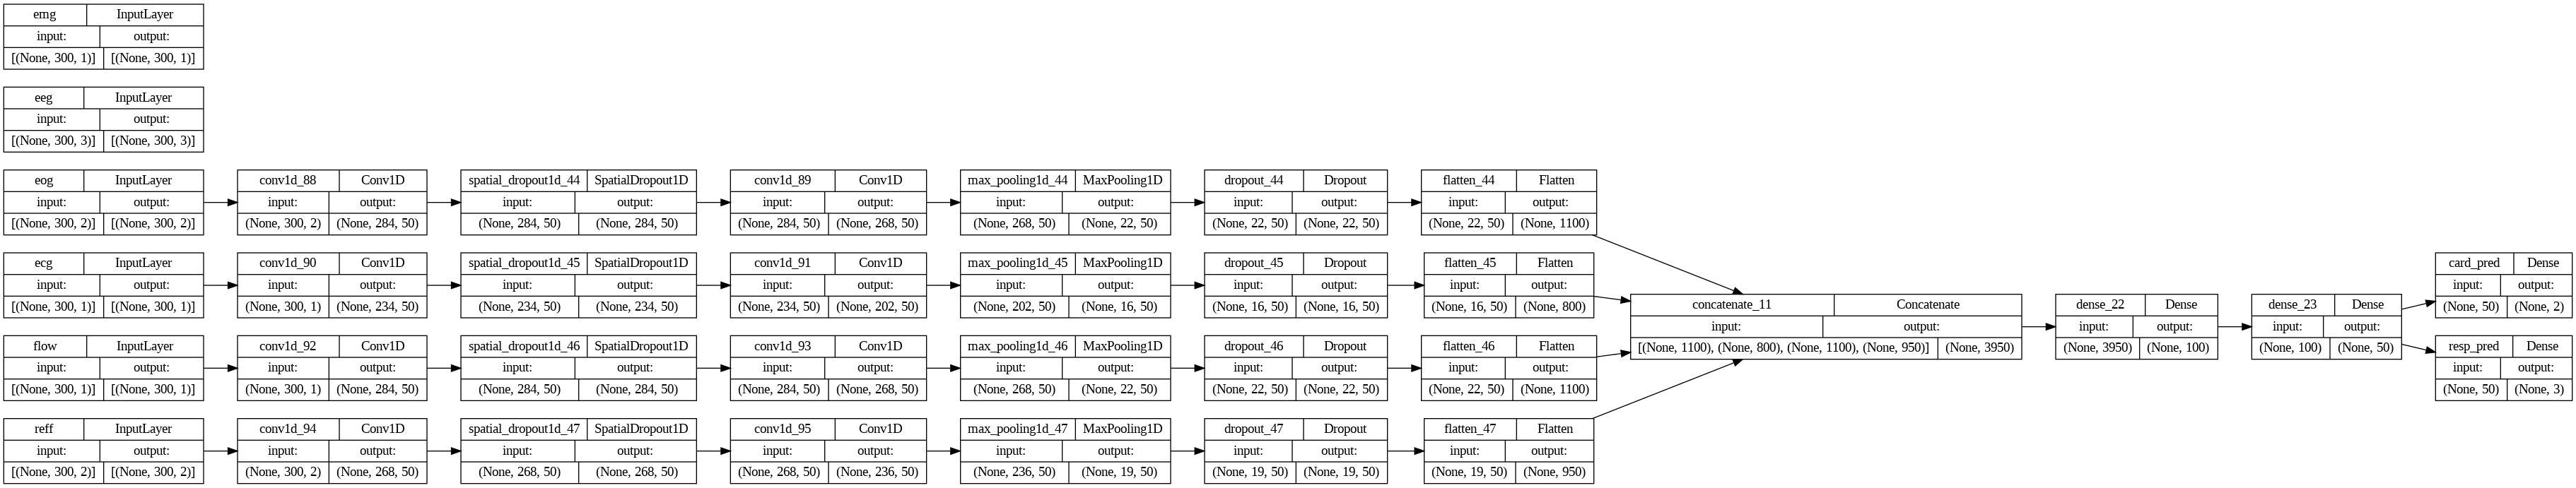

In [19]:
# topology and good article here
# https://blog.goodaudience.com/introduction-to-1d-convolutional-neural-networks-in-keras-for-time-sequences-3a7ff801a2cf
# ref for functional model https://keras.io/guides/functional_api/

def build_model(X_all_dict,y_all_dict):

    # input layers - 1st dim is timesteps, 2nd is features
    # this method give some configurability but lacks error checking.
    eeg_input = keras.Input(shape = (X_all_dict['eeg'].shape[1], X_all_dict['eeg'].shape[2]), name = "eeg")
    eog_input = keras.Input(shape = (X_all_dict['eog'].shape[1], X_all_dict['eog'].shape[2]), name = "eog")
    emg_input = keras.Input(shape = (X_all_dict['emg'].shape[1], X_all_dict['emg'].shape[2]), name = "emg")
    ecg_input = keras.Input(shape = (X_all_dict['ecg'].shape[1], X_all_dict['ecg'].shape[2]), name = "ecg")
    flow_input = keras.Input(shape = (X_all_dict['flow'].shape[1], X_all_dict['flow'].shape[2]), name = "flow")
    reff_input = keras.Input(shape = (X_all_dict['reff'].shape[1], X_all_dict['reff'].shape[2]), name = "reff")

    a = layers.Conv1D(filters=50, kernel_size=17, activation='relu')(eog_input)
    #https://www.tensorflow.org/api_docs/python/tf/keras/layers/SpatialDropout1D
    #SpatialDropout1D will help promote independence between feature maps [in early conv layers]"
    a = layers.SpatialDropout1D(0.25)(a)
    a = layers.Conv1D(filters=50, kernel_size=17, activation='relu')(a)
    a = layers.MaxPooling1D(pool_size=12)(a)
    a = layers.Dropout(0.25)(a)

    b = layers.Conv1D(filters=50, kernel_size=67, activation='relu')(ecg_input)
    b = layers.SpatialDropout1D(0.25)(b)
    b = layers.Conv1D(filters=50, kernel_size=33, activation='relu')(b)
    b = layers.MaxPooling1D(pool_size=12)(b)
    b = layers.Dropout(0.25)(b)

    c = layers.Conv1D(filters=50, kernel_size=17, activation='relu')(flow_input)
    c = layers.SpatialDropout1D(0.25)(c)
    c = layers.Conv1D(filters=50, kernel_size=17, activation='relu')(c)
    c = layers.MaxPooling1D(pool_size=12)(c)
    c = layers.Dropout(0.25)(c)

    d = layers.Conv1D(filters=50, kernel_size=33, activation='relu')(reff_input)
    d = layers.SpatialDropout1D(0.25)(d)
    d = layers.Conv1D(filters=50, kernel_size=33, activation='relu')(d)
    d = layers.MaxPooling1D(pool_size=12)(d)
    d = layers.Dropout(0.25)(d)

    #merged = layers.Concatenate(axis=1)([c, d]) 
    #merged = layers.GlobalAveragePooling1D()(merged)
    
    a = layers.Flatten()(a) # must pass tensor not as arg
    b = layers.Flatten()(b)
    c = layers.Flatten()(c)
    d = layers.Flatten()(d)

    merged = layers.Concatenate(axis=-1)([a,b,c,d])
    merged = layers.Dense(100, activation='relu')(merged)
    #merged = layers.Dropout(0.25)(merged)
    merged = layers.Dense(50, activation='relu')(merged)
    
    #n_outputs = y_resp.shape[1] 
    # this is going to be a pain between cardiac and resp until in model!
    card_pred = layers.Dense(2, activation='softmax', name='card_pred')(merged)

    resp_pred = layers.Dense(3, activation='softmax', name='resp_pred')(merged)

    model = keras.Model([eeg_input, eog_input, emg_input, ecg_input, flow_input, reff_input],
                        [card_pred, resp_pred])
    return model
if interactive:
    my_model = build_model(X_all_dict, y_all_dict)
    # model.summary()
    # pass rankdir="LR" to plot_model to display sideways
    display(keras.utils.plot_model(my_model, "my_model.png", show_shapes=True, rankdir = "LR"))


# Define function to train model

In [24]:
def train_model(model, X_train_dict, y_train_dict, 
                X_valid_dict, y_valid_dict,
                BATCH_SIZE = 256, # Larger batch sizes smooth loss curves
                NUM_EPOCHS = 50): # Max number run unless earlystopping callback fires

    callback = EarlyStopping(monitor='val_loss', mode = 'min', patience=10)
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

    # Despite some old examples online class weights cannot be used for multi-output models
    # class_weight={'card_pred':[1,10],'resp_pred':[1,2,10]} # just an educated guess...
    # class_weight={'card_pred':{0:1,1:10},'resp_pred':{0:1,1:2,3:10}} # just an educated guess...
    # class_weight={0: 1, 1: 10}
    # class_weight = [{0: 1, 1: 10},{0: 1, 1: 1, 2: 10}]

    sample_weights = {}
    sw_card = compute_sample_weight('balanced', y_train_dict['card'])
    sw_card = np.sqrt(sw_card) # no idea why weights are squared.
    sw_card = np.power(sw_card, 0.7) # to allow for tuning
    sample_weights['card_pred'] = sw_card

    sw_resp = compute_sample_weight('balanced', y_train_dict['resp'])
    sw_resp = np.sqrt(sw_resp) # no idea why weights are squared.
    sw_resp = np.power(sw_resp, 0.7) # to allow for tuning
    sample_weights['resp_pred'] = sw_resp
    # print("sample_weights",sample_weights) # this is a really long vector
    #unique, counts = np.unique(sample_weights, return_counts=True)
    #print("sample_weights values and counts:\n",str(np.asarray((unique, counts)).T))
    
    history = model.fit(
        {"eeg": X_train_dict['eeg'], "eog": X_train_dict['eog'], "emg": X_train_dict['emg'],
         "ecg": X_train_dict['ecg'], "flow": X_train_dict['flow'], "reff":X_train_dict['reff']},
         {"card_pred":y_train_dict['card'], "resp_pred":y_train_dict['resp']},
        batch_size = BATCH_SIZE,
        epochs=NUM_EPOCHS,
        callbacks=[callback],
        sample_weight=sample_weights,
        validation_data=({"eeg": X_valid_dict['eeg'], "eog": X_valid_dict['eog'], 
                          "emg": X_valid_dict['emg'], "ecg": X_valid_dict['ecg'],
                          "flow": X_valid_dict['flow'], "reff":X_valid_dict['reff']},
                         {"card_pred": y_valid_dict['card'], "resp_pred":y_valid_dict['resp']}),             
        verbose = 1) #0 = silent, 1 = progress bar, 2 = one line per epoch
    return history, model

## Run a stratified 5-fold group-based cross validation

Fold 0:
Epoch 1/50
136/136 [==============================] - 11s 51ms/step - loss: 2.5847 - card_pred_loss: 1.0398 - resp_pred_loss: 1.5450 - card_pred_accuracy: 0.7816 - resp_pred_accuracy: 0.6741 - val_loss: 1.3361 - val_card_pred_loss: 0.5797 - val_resp_pred_loss: 0.7564 - val_card_pred_accuracy: 0.8041 - val_resp_pred_accuracy: 0.6934
Epoch 2/50
136/136 [==============================] - 7s 49ms/step - loss: 1.2577 - card_pred_loss: 0.5794 - resp_pred_loss: 0.6783 - card_pred_accuracy: 0.8362 - resp_pred_accuracy: 0.7538 - val_loss: 1.2876 - val_card_pred_loss: 0.5492 - val_resp_pred_loss: 0.7384 - val_card_pred_accuracy: 0.7756 - val_resp_pred_accuracy: 0.7068
Epoch 3/50
136/136 [==============================] - 6s 47ms/step - loss: 1.2101 - card_pred_loss: 0.5705 - resp_pred_loss: 0.6397 - card_pred_accuracy: 0.8465 - resp_pred_accuracy: 0.7671 - val_loss: 1.2744 - val_card_pred_loss: 0.5380 - val_resp_pred_loss: 0.7365 - val_card_pred_accuracy: 0.7952 - val_resp_pred_accuracy:

dict_keys(['loss', 'card_pred_loss', 'resp_pred_loss', 'card_pred_accuracy', 'resp_pred_accuracy', 'val_loss', 'val_card_pred_loss', 'val_resp_pred_loss', 'val_card_pred_accuracy', 'val_resp_pred_accuracy'])
241/241 [==============================] - 1s 4ms/step


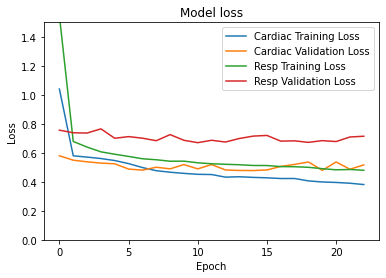

Fold 1:
Epoch 1/50
131/131 [==============================] - 12s 51ms/step - loss: 1.9943 - card_pred_loss: 0.7837 - resp_pred_loss: 1.2106 - card_pred_accuracy: 0.7387 - resp_pred_accuracy: 0.6950 - val_loss: 1.1588 - val_card_pred_loss: 0.4647 - val_resp_pred_loss: 0.6941 - val_card_pred_accuracy: 0.8706 - val_resp_pred_accuracy: 0.7386
Epoch 2/50
131/131 [==============================] - 6s 49ms/step - loss: 1.2173 - card_pred_loss: 0.5374 - resp_pred_loss: 0.6799 - card_pred_accuracy: 0.7921 - resp_pred_accuracy: 0.7538 - val_loss: 1.1508 - val_card_pred_loss: 0.4927 - val_resp_pred_loss: 0.6581 - val_card_pred_accuracy: 0.7723 - val_resp_pred_accuracy: 0.7318
Epoch 3/50
131/131 [==============================] - 6s 47ms/step - loss: 1.1293 - card_pred_loss: 0.5012 - resp_pred_loss: 0.6281 - card_pred_accuracy: 0.8172 - resp_pred_accuracy: 0.7745 - val_loss: 1.0397 - val_card_pred_loss: 0.4409 - val_resp_pred_loss: 0.5989 - val_card_pred_accuracy: 0.8574 - val_resp_pred_accuracy:

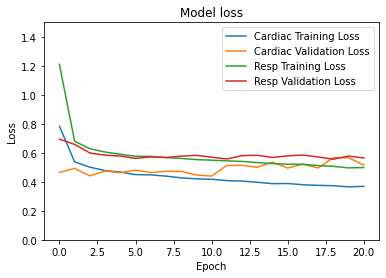

Fold 2:
Epoch 1/50
134/134 [==============================] - 11s 51ms/step - loss: 3.0049 - card_pred_loss: 1.3102 - resp_pred_loss: 1.6947 - card_pred_accuracy: 0.7586 - resp_pred_accuracy: 0.6953 - val_loss: 1.1972 - val_card_pred_loss: 0.4567 - val_resp_pred_loss: 0.7405 - val_card_pred_accuracy: 0.9192 - val_resp_pred_accuracy: 0.7301
Epoch 2/50
134/134 [==============================] - 6s 48ms/step - loss: 1.2688 - card_pred_loss: 0.5890 - resp_pred_loss: 0.6798 - card_pred_accuracy: 0.8127 - resp_pred_accuracy: 0.7584 - val_loss: 1.1562 - val_card_pred_loss: 0.4789 - val_resp_pred_loss: 0.6774 - val_card_pred_accuracy: 0.8947 - val_resp_pred_accuracy: 0.7570
Epoch 3/50
134/134 [==============================] - 6s 47ms/step - loss: 1.2128 - card_pred_loss: 0.5748 - resp_pred_loss: 0.6381 - card_pred_accuracy: 0.8038 - resp_pred_accuracy: 0.7712 - val_loss: 1.2126 - val_card_pred_loss: 0.5431 - val_resp_pred_loss: 0.6695 - val_card_pred_accuracy: 0.7796 - val_resp_pred_accuracy:

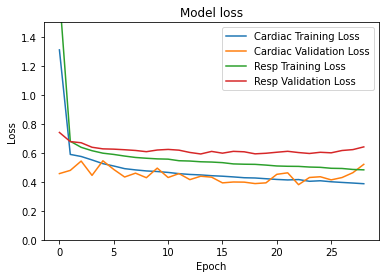

Fold 3:
Epoch 1/50
135/135 [==============================] - 11s 55ms/step - loss: 2.2029 - card_pred_loss: 0.8797 - resp_pred_loss: 1.3232 - card_pred_accuracy: 0.7680 - resp_pred_accuracy: 0.6748 - val_loss: 1.1823 - val_card_pred_loss: 0.5682 - val_resp_pred_loss: 0.6141 - val_card_pred_accuracy: 0.7609 - val_resp_pred_accuracy: 0.7868
Epoch 2/50
135/135 [==============================] - 7s 48ms/step - loss: 1.2503 - card_pred_loss: 0.5720 - resp_pred_loss: 0.6782 - card_pred_accuracy: 0.8384 - resp_pred_accuracy: 0.7526 - val_loss: 1.0646 - val_card_pred_loss: 0.5093 - val_resp_pred_loss: 0.5554 - val_card_pred_accuracy: 0.7999 - val_resp_pred_accuracy: 0.8100
Epoch 3/50
135/135 [==============================] - 7s 50ms/step - loss: 1.1976 - card_pred_loss: 0.5584 - resp_pred_loss: 0.6392 - card_pred_accuracy: 0.8515 - resp_pred_accuracy: 0.7702 - val_loss: 1.0602 - val_card_pred_loss: 0.5253 - val_resp_pred_loss: 0.5349 - val_card_pred_accuracy: 0.7857 - val_resp_pred_accuracy:

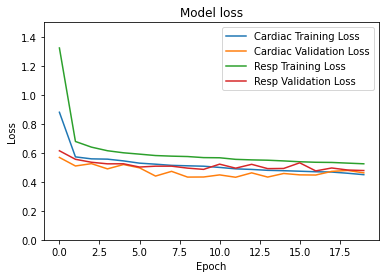

Fold 4:
Epoch 1/50
128/128 [==============================] - 11s 54ms/step - loss: 2.7071 - card_pred_loss: 1.2376 - resp_pred_loss: 1.4695 - card_pred_accuracy: 0.7423 - resp_pred_accuracy: 0.6630 - val_loss: 1.2385 - val_card_pred_loss: 0.5864 - val_resp_pred_loss: 0.6522 - val_card_pred_accuracy: 0.7313 - val_resp_pred_accuracy: 0.7894
Epoch 2/50
128/128 [==============================] - 6s 48ms/step - loss: 1.2963 - card_pred_loss: 0.5862 - resp_pred_loss: 0.7101 - card_pred_accuracy: 0.8095 - resp_pred_accuracy: 0.7425 - val_loss: 1.1978 - val_card_pred_loss: 0.5059 - val_resp_pred_loss: 0.6919 - val_card_pred_accuracy: 0.8470 - val_resp_pred_accuracy: 0.7719
Epoch 3/50
128/128 [==============================] - 6s 49ms/step - loss: 1.2444 - card_pred_loss: 0.5769 - resp_pred_loss: 0.6675 - card_pred_accuracy: 0.8093 - resp_pred_accuracy: 0.7621 - val_loss: 1.1028 - val_card_pred_loss: 0.4642 - val_resp_pred_loss: 0.6386 - val_card_pred_accuracy: 0.8576 - val_resp_pred_accuracy:

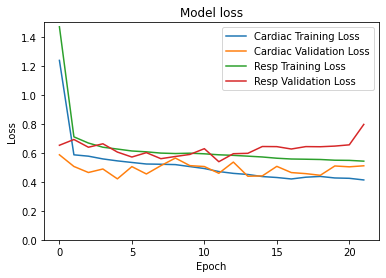

------------------------------------------------------------------------
Score per fold
> Fold 1 - Card > Loss: 0.52 - Accuracy: 75.16%
> Fold 1 - Resp > Loss: 0.71 - Accuracy: 73.18%
> Fold 2 - Card > Loss: 0.52 - Accuracy: 79.59%
> Fold 2 - Resp > Loss: 0.56 - Accuracy: 78.20%
> Fold 3 - Card > Loss: 0.52 - Accuracy: 76.84%
> Fold 3 - Resp > Loss: 0.64 - Accuracy: 75.85%
> Fold 4 - Card > Loss: 0.46 - Accuracy: 74.00%
> Fold 4 - Resp > Loss: 0.48 - Accuracy: 82.06%
> Fold 5 - Card > Loss: 0.51 - Accuracy: 79.96%
> Fold 5 - Resp > Loss:  0.8 - Accuracy: 80.80%
------------------------------------------------------------------------
Average scores for all folds:
> Card Accuracy: 77.11 (+- 2.362)
> Reso Accuracy: 78.02 (+- 3.232)
------------------------------------------------------------------------
Total Training time = 0:13:25 HH:MM:SS


In [25]:
# Define per-fold score containers
card_acc_per_fold = []
card_loss_per_fold = []
card_y_pred_per_fold = []
card_y_valid_per_fold = []
resp_acc_per_fold = []
resp_loss_per_fold = []
resp_y_pred_per_fold = []
resp_y_valid_per_fold = []

skf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)

start_time = time.time()

for i, (train_index, valid_index) in enumerate(skf.split(X, y[:,0], groups=sub)):
        print(f"Fold {i}:")
        #print(len(train_index), train_index)
        #print(len(valid_index), valid_index)

        # More complicated with dictionary of multiple inputs.
        # iterate through all keys and add the proper index array

        X_train_dict = {}
        X_valid_dict = {}
        y_train_dict = {}
        y_valid_dict = {}

        for key,item in X_all_dict.items():
            X_train_dict[key] = item[train_index]
            X_valid_dict[key] = item[valid_index]
        for key,item in y_all_dict.items():
            y_train_dict[key] = item[train_index]
            y_valid_dict[key] = item[valid_index]
        
        # for key,item in X_train_dict.items():
        #     print(key,item.shape)
        # for key,item in y_train_dict.items():
        #     print(key,item.shape)
        # for key,item in X_valid_dict.items():
        #     print(key,item.shape)
        # for key,item in y_valid_dict.items():
        #     print(key,item.shape)

        # TODO:  Move one-hot into model
        enc = OneHotEncoder(handle_unknown = 'ignore', sparse_output=False)
        y_train_dict['card'] = enc.fit_transform(y_train_dict['card'])
        y_valid_dict['card'] = enc.transform(y_valid_dict['card'])

        y_train_dict['resp'] = enc.fit_transform(y_train_dict['resp'])
        y_valid_dict['resp'] = enc.transform(y_valid_dict['resp'])

        # print(y_train_resp.shape)
        # print(y_valid_resp.shape)

        my_model = build_model(X_train_dict, y_train_dict)
        history, model = train_model(my_model, X_train_dict, y_train_dict, X_valid_dict, y_valid_dict)

        if (i == 0):  # saving arrays and model for debugging
            np.save('X_valid_dict.npy', X_valid_dict)
            np.save('y_valid_dict.npy', y_valid_dict)
            #read_dictionary = np.load('my_file.npy',allow_pickle='TRUE').item()
            my_model.save('my_model')
            print(history.history.keys())
            #model = keras.models.load_model('path/to/location')

        val_card_acc = history.history['val_card_pred_accuracy'][-1]
        val_card_loss = history.history['val_card_pred_loss'][-1] 
        card_acc_per_fold.append(val_card_acc * 100)
        card_loss_per_fold.append(val_card_loss)

        val_resp_acc = history.history['val_resp_pred_accuracy'][-1]
        val_resp_loss = history.history['val_resp_pred_loss'][-1] 
        resp_acc_per_fold.append(val_resp_acc * 100)
        resp_loss_per_fold.append(val_resp_loss)
                
        # Generate predictions
        y_pred = model.predict(X_valid_dict)

        card_y_pred = np.argmax(y_pred[0], axis=1)
        card_y_pred_per_fold.append(card_y_pred)
        card_y_valid_per_fold.append(np.argmax(y_valid_dict['card'], axis=1))

        resp_y_pred = np.argmax(y_pred[1], axis=1)
        resp_y_pred_per_fold.append(resp_y_pred)
        resp_y_valid_per_fold.append(np.argmax(y_valid_dict['resp'], axis=1))

        # Plot training & validation loss values
        plt.plot(history.history['card_pred_loss'], label="Cardiac Training Loss")
        plt.plot(history.history['val_card_pred_loss'],label="Cardiac Validation Loss")
        plt.plot(history.history['resp_pred_loss'],label="Resp Training Loss")
        plt.plot(history.history['val_resp_pred_loss'],label="Resp Validation Loss")
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.ylim([0,1.5]) #set limit - 1.2 has been a good value experimentally
        plt.legend(loc='upper right')
        plt.show()

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(card_acc_per_fold)):
#     print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Card > Loss: {card_loss_per_fold[i]:4.2} - Accuracy: {card_acc_per_fold[i]:4.2f}%')
    print(f'> Fold {i+1} - Resp > Loss: {resp_loss_per_fold[i]:4.2} - Accuracy: {resp_acc_per_fold[i]:4.2f}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Card Accuracy: {np.mean(card_acc_per_fold):4.2f} (+- {np.std(card_acc_per_fold):5.4})')
print(f'> Reso Accuracy: {np.mean(resp_acc_per_fold):4.2f} (+- {np.std(resp_acc_per_fold):5.4})')
card_acc_str = temp = str(f'> Card Accuracy: {np.mean(card_acc_per_fold):4.2f} (+- {np.std(card_acc_per_fold):5.4})')
resp_acc_str = temp = str(f'> Resp Accuracy: {np.mean(resp_acc_per_fold):4.2f} (+- {np.std(resp_acc_per_fold):5.4})')
print('------------------------------------------------------------------------')

# Show total training time
end_time = time.time()
train_time = timedelta(seconds=(end_time - start_time))
print('Total Training time =',(str(train_time).split(".")[0]), 'HH:MM:SS')
# to plot confusion matrices return concat versions of y
card_y_pred = np.concatenate(card_y_pred_per_fold)
card_y_valid = np.concatenate(card_y_valid_per_fold)
resp_y_pred = np.concatenate(resp_y_pred_per_fold)
resp_y_valid = np.concatenate(resp_y_valid_per_fold)
#return acc_str, y_pred, y_test

In [ ]:
# For debugging
# my_model = keras.models.load_model('my_model')
# X_valid_dict = np.load('X_valid_dict.npy',allow_pickle='TRUE').item()
# y_pred = my_model.predict(X_valid_dict)
# print(y_pred[0])

# Save each confusion matrix separately, then plot/save side-by-side

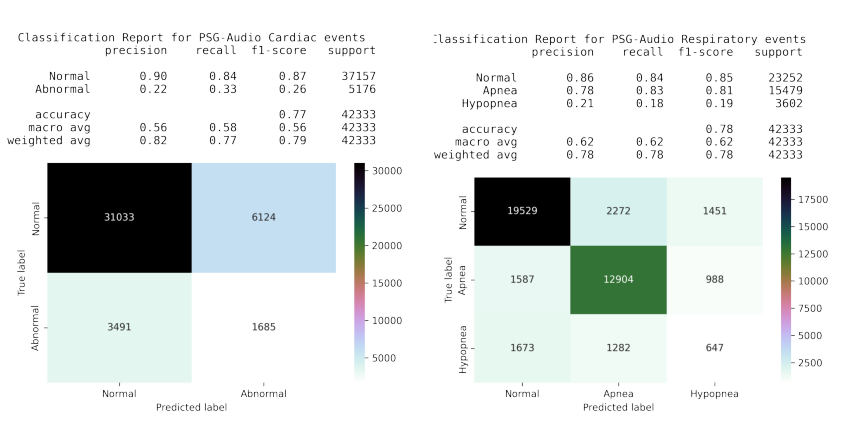

In [26]:
# much of this leveraged from tsmodel_throwdown in load_data_time_series
label_names = ['Cardiac','Respiratory']

#acknowledgement to @MikeHordecki https://stackoverflow.com/questions/522563/accessing-the-index-in-for-loops
for idx, curr_lname in enumerate(label_names):   
    if (idx == 0):
        y_valid = card_y_valid
        y_pred =  card_y_pred
        class_names = ['Normal','Abnormal'] # cardiac events
    elif (idx == 1):
        y_valid = resp_y_valid
        y_pred =  resp_y_pred
        class_names = ['Normal','Apnea','Hypopnea'] # Rep events
    else:
        print ("Something went wrong!")
        model = None # just to keep from running erroneous pass

    class_rpt = 'Classification Report for PSG-Audio ' + curr_lname + ' events\n'
    class_rpt += (classification_report(y_valid, y_pred, target_names = class_names))
    #y_test_act = np.argmax(y_test, axis=-1) # undo one-hot encoding

    cm = confusion_matrix(y_valid, y_pred)
    cm_df = pd.DataFrame(cm,
                        index = class_names, 
                        columns = class_names)
    cm_height = 6 # was 1.2*len(t_names)/2
    cm_width = 6 # was len(t_names)/2)
    fig = plt.figure(figsize=(cm_width,cm_height)) # num classes => size
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='cubehelix_r')
    #plt.title(curr_mname +' using '+dataset+'\nAccuracy:{0:.3f}'.format(accuracy_score(y_test_act, y_pred)))
    #plt.title('PSG-Audio:' + curr_lname)
    font_title = {'family':'monospace','color':'black','size':12}
    plt.title(class_rpt, fontdict = font_title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout() # keeps labels from being cutoff when saving as pdf
    cmplot_name = 'psg-audio_'+ curr_lname + '_cm.png'
    plt.savefig(cmplot_name, dpi = 300) 
    plt.close() # otherwise plots still get displayed even w/o plt.show()
    #plt.show()

# read in plots and show side-by-side
fig, axs = plt.subplots(nrows=1, ncols=2)#, figsize = (40,10))
fig.set_size_inches(12,24)
axs[0].set_axis_off() # so outer boarder and numbers do not appear
axs[1].set_axis_off()
axs[0].imshow(plt.imread('psg-audio_Cardiac_cm.png'))
axs[1].imshow(plt.imread('psg-audio_Respiratory_cm.png'))
plt.tight_layout()
plt.savefig('psg-audio_Card_Resp_cm.png', dpi = 300) # don't forget to download!
plt.show()

# STOP - the following code is to load the data from and save figures to google drive.
You are welcome to use it, but it is untested outside of my environment.

In [ ]:
def get_load_data_utils():
    """checks for local file, if none downloads from IMICS repository.
    Assumes a global my_dir has been defined (default is my_dir = ".")
    :return: nothing"""
    fname = 'load_data_utils.py'
    ffname = os.path.join(my_dir,fname)
    if (os.path.exists(ffname)):
        print ("Local load_data_utils.py found, skipping download")
    else:
        print("Downloading",fname, "from IMICS git repo")
        urllib.request.urlretrieve("https://raw.githubusercontent.com/imics-lab/load_data_time_series/main/load_data_utils.py", filename=fname)
if interactive:
    get_load_data_utils()

In [ ]:
from load_data_utils import get_env_info
from load_data_utils import get_log_ffname
from load_data_utils import tabulate_numpy_arrays
from load_data_utils import channel_powerset
if interactive:
    print('My env_info: \n' + get_env_info())

My env_info: 
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
GPU: name, driver_version, memory.total [MiB]
Tesla T4, 510.47.03, 15360 MiB



In [ ]:
save_log = False # set to False to avoid a problem if accidentally run...
# alternate confusion matrix with fig object to save
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm,
                    index = class_names, 
                    columns = class_names)
fig = plt.figure(figsize=(6.5,5))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='cubehelix_r')
#plt.title('Insert title here\n
#plt.title('Accuracy:{0:.3f}'.format(accuracy_score(y_test, y_pred)))
plt.title('Accuracy:{0:.3f}'.format(accuracy_score(y_test, y_pred)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout() # keeps labels from being cutoff when saving as pdf
plt.show()
if save_log:
    log_ffname = get_log_ffname(
    log_file_dir = '/content/drive/My Drive/Colab_Run_Results',
    base_fname = "PSG_Multi_Output_Work")
    print("Saving results to", log_ffname)
    with open(log_ffname, "a") as file_object:
        file_object.write("Generated by Evaluate_Model_PSG-Audio.ipynb\n")
        file_object.write("Processed PSG with 5 fold via sklearn GroupKFold\n")
        file_object.write("Final Accuracy: %0.3f\n" %accuracy_score(y_test, y_pred))
        file_object.write("Classification Report\n")
        file_object.write(classification_report(y_test, y_pred, target_names=class_names))
        file_object.write("Confusion Matrix\n")
        file_object.write(str(cm))
    cm_ffname = log_ffname.split('.')[0] + '_cm.pdf'
    print("saving cm plot as",cm_ffname)
    fig.savefig(cm_ffname,format='pdf', dpi=1200)
    full_model_fname = log_ffname.split('.')[0] + '_model.txt'
    with open(full_model_fname, "a") as file_object:
        model.summary(print_fn=lambda x: file_object.write(x + '\n'))
        #acknowledgement https://stackoverflow.com/users/14951382/sparklingdew
    #plot using keras function
    #ref https://keras.io/api/utils/model_plotting_utils/
    full_mplot_fname = log_ffname.split('.')[0] + '_model.png'
    keras.utils.plot_model(model, to_file=full_mplot_fname, show_shapes=True)